In [4]:
import re
import pandas as pd
from io import StringIO

FILENAME = './data/train.csv'
with open(FILENAME) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
  df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

print(df)

ParserError: Error tokenizing data. C error: Expected 50 fields in line 3, saw 55


### Check amount of predictive words per target class


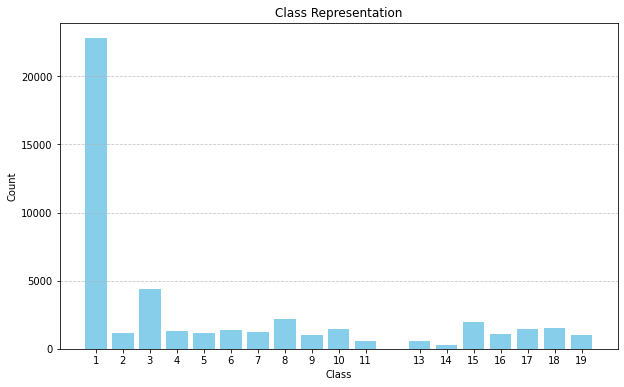

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_representation(dataframe):
    # Extract Labels column
    labels_column = dataframe['Labels']
    
    # Split the labels by space and convert them to integers
    labels_list = labels_column.str.split().explode().astype(int)
    
    # Count the occurrences of each label
    label_counts = labels_list.value_counts().sort_index()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.index, label_counts.values, color='skyblue')
    plt.title('Class Representation')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(label_counts.index)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_representation(df)


## Manual Review of Data and Labelling

| Label | Guess                  |
|-------|------------------------|
| 1     | person??               |
| 2     | 2 wheel bike vehicle   |
| 3     | general vehicle? Car maybe |
| 4     | motorbike?             |
| 5     | plane                  |
| 6     | bus?                   |
| 7     | train                  |
| 8     | road??                 |
| 9     | boat / learned water?  |
| 10    | traffic lights? / signs|
| 11    | fire hydrant           |
| 13    | stop sign / sign       |
| 14    | parking meter          |
| 15    | bench                  |
| 16    | bird                   |
| 17    | cat                    |
| 18    | dog                    |
| 19    | horse                  |


In [81]:
def find_labels_containing_x(dataframe, class_find):
    """Helper method used to find rows with a certain class for visualisation"""
    rows_with_x = []
    
    # Loop over the DataFrame
    for index, row in dataframe.iterrows():
        labels = str(row['Labels']).split(" ")
        #print(labels)

        if class_find in labels:
            rows_with_x.append(row["ImageID"])
    
    return rows_with_x




In [132]:
from PIL import Image
import matplotlib.pyplot as plt

single_classed_labels = find_labels_containing_x(df, class_find="2")

def display_image(file_name):
    # Open the image file
    image = Image.open(file_name)
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

#Loop over the data to find 20 images with the specified class
k = 0
for i in single_classed_labels:
    file_name = "data/images/{}".format(i)
    #display_image(file_name)
    k += 1
    if k >= 20:
        break


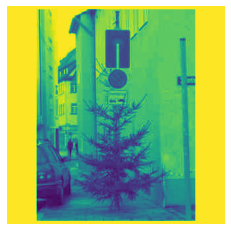

Processed image shape: (330, 330)


In [138]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess_image(image_path, width, height):
    """Preprocessing function used to do the following:
    1. Greyscale the images
    2. Resize the images by padding with white space
    3. Normalize images by division of 255"""
    # Display the original image
    
    image = cv2.imread(image_path)
    #display_image(image_path) #Used for visualising effect of preprocessing
    #print("Original image size: {}".format(image.shape))
    
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Get the dimensions of the grayscale image
    current_height, current_width = grayscale_image.shape[:2]
    # Calculate the amount of padding needed
    pad_width = max(width - current_width, 0)
    pad_height = max(height - current_height, 0)
    
    # Calculate the padding values
    top = pad_height // 2
    bottom = pad_height - top
    left = pad_width // 2
    right = pad_width - left
    
    # Pad the grayscale image with white space
    padded_image = cv2.copyMakeBorder(grayscale_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255))
    
    # Resize the padded image to the specified width and height
    resized_image = cv2.resize(padded_image, (width, height))

    #normalize image by division of 255.0
    resized_image = resized_image / 255.0
    
    # Display the resized image
    plt.imshow(resized_image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

    return resized_image

preprocessed_image = preprocess_image("./data/images/39988.jpg", 330, 330)

print("Processed image shape: {}".format(preprocessed_image.shape))


## Find max height and width of images

In [139]:
import os
import numpy as np
from PIL import Image

def find_image_sizes(directory):
    image_sizes = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            # Open the image file
            image_path = os.path.join(directory, filename)
            with Image.open(image_path) as img:
                # Get the dimensions of the image
                width, height = img.size
                # Append size to the list
                image_sizes.append((width, height))
    
    return image_sizes

def calculate_stats(image_sizes):
    # Convert list of tuples to numpy array for easier calculations
    image_sizes_array = np.array(image_sizes)
    
    # Calculate max, min, and standard deviation
    max_size = np.max(image_sizes_array, axis=0)
    min_size = np.min(image_sizes_array, axis=0)
    std_dev = np.std(image_sizes_array, axis=0)
    
    return max_size, min_size, std_dev

# Example usage:
directory = "./data/images/"  # Replace "images" with the directory containing your images
image_sizes = find_image_sizes(directory)
max_size, min_size, std_dev = calculate_stats(image_sizes)

print("Max Size:", max_size)
print("Min Size:", min_size)
print("Standard Deviation of Size:", std_dev)


Max Size: [320 320]
Min Size: [29 25]
Standard Deviation of Size: [45.84001473 48.45425533]


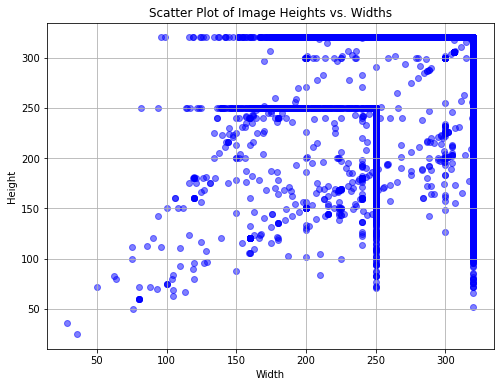

In [112]:

widths, heights = zip(*image_sizes)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, color='blue', alpha=0.5)
plt.title('Scatter Plot of Image Heights vs. Widths')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.show()

### Pre-Process all Data

In [4]:
import os
import cv2

def process_directory(input_directory, output_directory, width, height):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.lower().endswith((".jpeg", ".jpg")):
            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, filename)

            # Process the image
            preprocessed_image = preprocess_image(input_path, width, height)

            preprocessed_image = (preprocessed_image * 255).astype(np.uint8)
            cv2.imwrite(output_path, preprocessed_image)

input_directory = './data/images'
output_directory = './processeddata/processed_images'
process_directory(input_directory, output_directory, 330, 330)


### Check label correspondence with tokens

In [2]:
train = pd.read_csv('./processed-data/train.csv', converters={'EncodedLabels': pd.eval, 'TokensWithPadding': pd.eval, 'Tokens':pd.eval, 'LabelIds':pd.eval})

In [27]:
train

,Unnamed: 0,ImageID,Labels,Caption,Tokens,LabelIds,EncodedLabels,DictionaryIds,TokensWithPadding
0,0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,"[woman, swim, suit, holding, parasol, sunny, day]",[0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7236, 6376, 6297, 3077, 4457, 6316, 1714]","[7236, 6376, 6297, 3077, 4457, 6316, 1714, 0, ..."
1,1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,"[couple, men, riding, horses, top, green, field]","[0, 17]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1524, 3891, 5237, 3117, 6650, 2827, 2351]","[1524, 3891, 5237, 3117, 6650, 2827, 2351, 0, ..."
2,2,2.jpg,[1],They are brave for riding in the jungle on tho...,"[brave, riding, jungle, eleph]",[0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[754, 5237, 3368, 2093]","[754, 5237, 3368, 2093, 0, 0, 0, 0, 0, 0, 0, 0..."
3,3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,"[black, silver, clock, tower, intersection, ne...","[7, 2, 11]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[616, 5718, 1257, 6684, 3267, 4138, 6738]","[616, 5718, 1257, 6684, 3267, 4138, 6738, 0, 0..."
4,4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,"[train, coming, stop, tracks, sid]","[7, 2, 6]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...","[6704, 1367, 6178, 6694, 5677]","[6704, 1367, 6178, 6694, 5677, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
29991,29991,29995.jpg,"[8, 1, 2]",A picture of a truck that is in the middle of ...,"[picture, truck, middle, road]","[7, 0, 1]","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[4657, 6782, 3932, 5265]","[4657, 6782, 3932, 5265, 0, 0, 0, 0, 0, 0, 0, ..."
29992,29992,29996.jpg,[1],A plate topped with a pizza being cut with a s...,"[plate, topped, pizza, cut, spoon]",[0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4743, 6653, 4712, 1680, 6039]","[4743, 6653, 4712, 1680, 6039, 0, 0, 0, 0, 0, ..."
29993,29993,29997.jpg,[1],A man riding a snowboard on top of snow.,"[man, riding, snowboard, top, snow]",[0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3778, 5237, 5900, 6650, 5897]","[3778, 5237, 5900, 6650, 5897, 0, 0, 0, 0, 0, ..."
29994,29994,29998.jpg,[1],This photo shows people skiing in the mountains.,"[photo, shows, people, skiing, mountain]",[0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4627, 5658, 4586, 5775, 4047]","[4627, 5658, 4586, 5775, 4047, 0, 0, 0, 0, 0, ..."


In [28]:
temp = train.drop(columns=["Unnamed: 0", "ImageID", "Labels", "Caption", "EncodedLabels", "DictionaryIds", "TokensWithPadding"])

In [29]:
temp

,Tokens,LabelIds
0,"[woman, swim, suit, holding, parasol, sunny, day]",[0]
1,"[couple, men, riding, horses, top, green, field]","[0, 17]"
2,"[brave, riding, jungle, eleph]",[0]
3,"[black, silver, clock, tower, intersection, ne...","[7, 2, 11]"
4,"[train, coming, stop, tracks, sid]","[7, 2, 6]"
...,...,...
29991,"[picture, truck, middle, road]","[7, 0, 1]"
29992,"[plate, topped, pizza, cut, spoon]",[0]
29993,"[man, riding, snowboard, top, snow]",[0]
29994,"[photo, shows, people, skiing, mountain]",[0]


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#type(train["Tokens"][0])


In [4]:
co_occurrences = {}
for i in range(19):
    co_occurrences[i] = {"total count": 0}

for idx, row in train.iterrows():
    labels = row["LabelIds"]
    words = row["Tokens"]
    for i in labels:
        co_occurrences[i]["total count"] += 1
        for word in words:
            if word in co_occurrences[i].keys():

                co_occurrences[i][word] += 1
            else:
                co_occurrences[i][word] = 1

In [12]:
print(co_occurrences[0])

{'total count': 22794, 'woman': 2532, 'swim': 8, 'suit': 190, 'holding': 2179, 'parasol': 9, 'sunny': 42, 'day': 124, 'couple': 659, 'men': 835, 'riding': 1628, 'horses': 174, 'top': 982, 'green': 381, 'field': 815, 'brave': 2, 'jungle': 1, 'eleph': 76, 'young': 1361, 'man': 5535, 'skateboard': 737, 'air': 460, 'motor': 54, 'bike': 192, 'across': 178, 'forest': 48, 'skate': 212, 'park': 348, 'next': 1631, 'body': 84, 'water': 221, 'cutting': 172, 'pizza': 441, 'fork': 28, 'knife': 38, 'sitting': 2155, 'girl': 643, 'cut': 58, 'big': 160, 'cak': 187, 'piece': 128, 'cake': 186, 'coffee': 36, 'outdoor': 97, 'people': 2724, 'gathered': 41, 'outside': 202, 'cloudy': 45, 'stop': 133, 'sign': 264, 'directs': 1, 'pedestrians': 21, 'train': 583, 'travels': 4, 'bi': 31, 'female': 78, 'military': 31, 'uniform': 102, 'businessman': 3, 'neck': 51, 'ti': 123, 'six': 16, 'snowboards': 20, 'propped': 8, 'snow': 776, 'rail': 80, 'traveler': 1, 'leaning': 65, 'luggage': 124, 'cart': 62, 'sampling': 1, 'w

In [24]:
for i in co_occurrences:
    for word in co_occurrences[i]:
        if word == "total count":
            continue
        #get % of total
        new_dict = {}
        if co_occurrences[i][word] / co_occurrences[i]["total count"] < 0.05:
            new_dict[word]=co_occurrences[i][word]
    print(new_dict)
    break

{'trainer': 1}


In [32]:
print(co_occurrences[0])

{'total count': 22794, 'woman': 2532, 'suit': 190, 'holding': 2179, 'parasol': 9, 'sunny': 42, 'day': 124, 'couple': 659, 'men': 835, 'riding': 1628, 'horses': 174, 'top': 982, 'green': 381, 'field': 815, 'brave': 2, 'jungle': 1, 'eleph': 76, 'young': 1361, 'man': 5535, 'skateboard': 737, 'air': 460, 'motor': 54, 'bike': 192, 'across': 178, 'forest': 48, 'skate': 212, 'park': 348, 'next': 1631, 'body': 84, 'water': 221, 'cutting': 172, 'pizza': 441, 'fork': 28, 'knife': 38, 'sitting': 2155, 'girl': 643, 'cut': 58, 'big': 160, 'cak': 187, 'piece': 128, 'cake': 186, 'coffee': 36, 'outdoor': 97, 'people': 2724, 'gathered': 41, 'outside': 202, 'cloudy': 45, 'stop': 133, 'sign': 264, 'directs': 1, 'pedestrians': 21, 'train': 583, 'travels': 4, 'bi': 31, 'female': 78, 'military': 31, 'uniform': 102, 'businessman': 3, 'neck': 51, 'ti': 123, 'six': 16, 'snowboards': 20, 'propped': 8, 'snow': 776, 'rail': 80, 'traveler': 1, 'leaning': 65, 'luggage': 124, 'cart': 62, 'sampling': 1, 'wine': 98, '

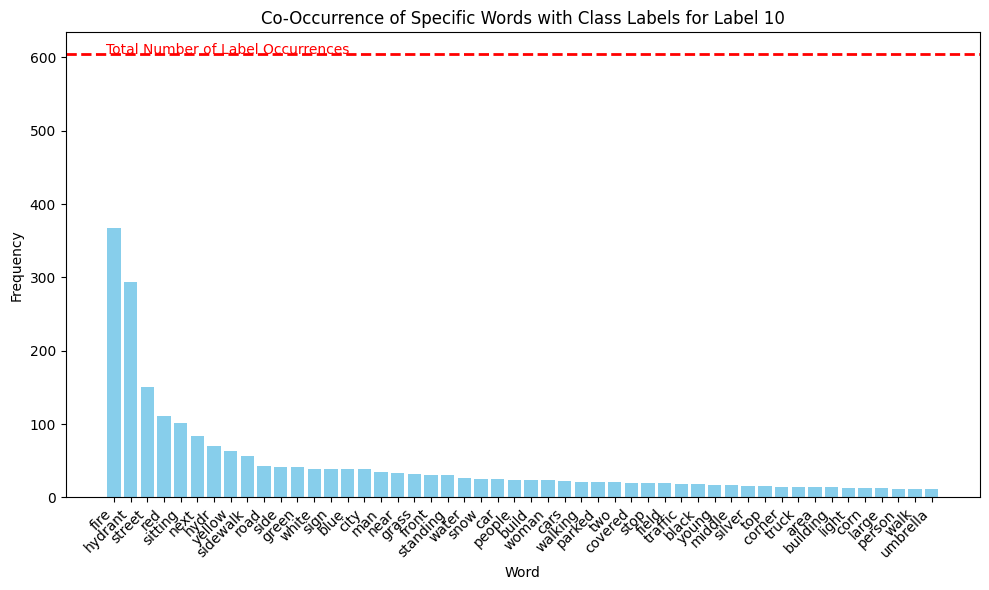

In [85]:
target_label = 10
sorted_items = sorted(co_occurrences[target_label].items(), key=lambda x: x[1], reverse=True)
# Extract sorted keys and values into separate lists
sorted_keys = [item[0] for item in sorted_items][1:51]
sorted_values = [item[1] for item in sorted_items][1:51]


# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(sorted_keys, sorted_values, color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Co-Occurrence of Specific Words with Class Labels for Label {}'.format(target_label))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.axhline(y=co_occurrences[target_label]["total count"], color='red', linestyle='--', linewidth=2)
plt.text(-0.5, co_occurrences[target_label]["total count"], 'Total Number of Label Occurrences', color='red')
plt.show()